In [1]:
%load_ext autoreload
%autoreload 2
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig,LoopbackInterface
import numpy as np
import matplotlib.pyplot as plt


# The `measure` command

The OPX has two analog to digital converters able to sample analog signals at 1 giga-sample per second (GSPS). 

The data obtained by this measurement can be accessed as a "raw" stream, meaning you simply obtain the digitized voltage values, between -0.5V and 0.5V. 
However, you can do much more than that. The measure command can combine measured samples in different ways, to provide a weighted sum (integration) of the samples, demodulate the signal, provide a vector of time stamps if the signal is composed of multiple rectangular pulses (time-tagging) and more. 

The measurement command always plays a pulse which performing the measurement. The idea behind this is that you almost always need to drive the system you are measuring. You are going to be measuring reflection, fluorescence or something similar and so it stands to reason you also need to play a pulse to generate these effects.

The configuration below defines a quantum element working at DC. That element has an input on OPX ADC 1 and and output on the OPX DAC 1. Unlike previous configurtion files in these notebooks, it also includes a section called `integration_weights`. Defining weights is mandatory when using integration or demodulation becasue, as stated above, the integration is a _weighted_ sum. 

In [2]:
pulse_len = 1000
long_pulse_len=50000

config = {
    "version": 1,
    "controllers": {
        "con1": {
            "type": "opx1",
            "analog_outputs": {
                1: {"offset": +0.0},
            },
            "analog_inputs": {
                1: {"offset": +0.0},
            },
        }
    },
    "elements": {
        "qe1": {
            "singleInput": {"port": ("con1", 1)},
            "outputs": {"output1": ("con1", 1)},
            "intermediate_frequency": 0e6,
            "operations": {
                "readoutOp": "readoutPulse",
                "readoutOp2": "readoutPulse2",
            },
            "time_of_flight": 180,
            "smearing": 0,
        },
    },
    "pulses": {
        "readoutPulse": {
            "operation": "measure",
            "length": pulse_len,
            "waveforms": {"single": "const_wf"},
            "digital_marker": "ON",
            "integration_weights": {"x": "xWeights", "y": "yWeights"},
        },
        "readoutPulse2": {
            "operation": "measure",
            "length": long_pulse_len,
            "waveforms": {"single": "const_wf"},
            "digital_marker": "ON",
            "integration_weights": {"x": "xWeights2", "y": "yWeights2"},
        },
    },
    "waveforms": {
        "const_wf": {"type": "constant", "sample": 0.2},
        
    },
    "digital_waveforms": {
        "ON": {"samples": [(1, 0)]},
    },
    "integration_weights": {
        "xWeights": {
            "cosine": [1.0] * (pulse_len // 4),
            "sine": [1.0] * (pulse_len // 4),
        },
        "yWeights": {
            "cosine": [1.0] * (pulse_len // 4),
            "sine": [1.0] * (pulse_len // 4),
        },
        "xWeights2": {
            "cosine": [1.0] * (long_pulse_len // 4),
            "sine": [1.0] * (long_pulse_len // 4),
        },
        "yWeights2": {
            "cosine": [1.0] * (long_pulse_len // 4),
            "sine": [1.0] * (long_pulse_len // 4),
        },
    },
}


## Integration and raw measurement

We will now discuss a program that uses several features we have not yet discussed. There is a declaration of variable `I = declare(fixed)`, the `measure` command itself, the `save` command and something called the `LoopbackInterface`.

The setup is as follows: we use `LoopbackInterface` to tell the simulator to connect output number 1 to input number 1. We can then measure what we play, and manipulate that data. The QUA program declares a variable `I` which has a `fixed` number type. This is a decimal number representation which is one of the 3 data types we currently support in QUA (`int`, `fixed` & `bool`). We then use the `meausre` command and do two things: 

1. save the samples measured by the ADC to a stream of data that we call "raw" (but we could have called it anything else)
2. apply the `integration` operator, that takes all the input samples and sums them together (applying the weight vector)

The `integration` operator populates the `I` variable, but if we want to be able to access it outside the QUA program we also need to save it. We do this with the `save` command. Here, again we save its value to a named stream which we also called `"I"`, but we could have called it anything at all.


2021-03-30 18:47:48,896 - qm - INFO - Performing health check
2021-03-30 18:47:48,904 - qm - INFO - Health check passed
2021-03-30 18:47:49,101 - qm - WARNING - streaming adc data without adc_trace flag might cause performance issues
2021-03-30 18:47:49,107 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-30 18:47:49,323 - qm - INFO - Flags: 
2021-03-30 18:47:49,323 - qm - INFO - Simulating Qua program

Raw ADC stream


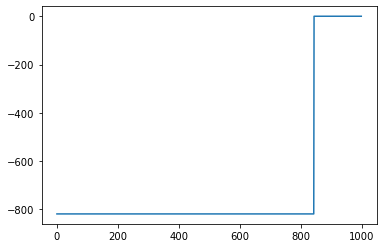


Integration result = [-0.04120088]


In [3]:

QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()
QM1 = QMm.open_qm(config)



with program() as measureProg:
    I = declare(fixed)
    measure("readoutOp", "qe1", "raw", integration.full("x", I))
    save(I,"I")
    
job = QM1.simulate(measureProg,SimulationConfig(1000, simulation_interface=LoopbackInterface([("con1", 1, "con1", 1)])),)
res = job.result_handles
print(f"\nRaw ADC stream")
print(f"================")
plt.figure()
plt.plot(res.raw_input1.fetch_all()['value'])
plt.show()
I=res.I.fetch_all()['value']
print(f"\nIntegration result = {I}")

## Segmented integration

The `integrate` command is quite versatile. It need not only sum all the samples in a vector. It can also perform a moving-window integration, sliced integration and other things you can read about in the [docs](https://qm-docs.s3.amazonaws.com/v0.8/python/features.html?highlight=integration). 

This is already an advanced topic given the duration of this workshop, so we will just give one example. 

The idea is to perform the integration in several non-overlapping segments. This allows to perform data size reduction (you turn many points into few) and is effectively a noise filter as noise in each segment is averaged out (if it's fast compared to the window size in time). You can customize how it's done by tweaking the integration weights. In this case we just use a uniform integration weight throughout. 

You can play with the number of segments and see how the sine curve on the bottom panel (which is sampled at 1 GSPS) is turned into a few-point representation of the same signal.

2021-03-30 18:47:50,962 - qm - INFO - Performing health check
2021-03-30 18:47:50,966 - qm - INFO - Health check passed
2021-03-30 18:47:51,329 - qm - WARNING - streaming adc data without adc_trace flag might cause performance issues
2021-03-30 18:47:51,349 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-03-30 18:47:51,796 - qm - INFO - Flags: 
2021-03-30 18:47:51,796 - qm - INFO - Simulating Qua program


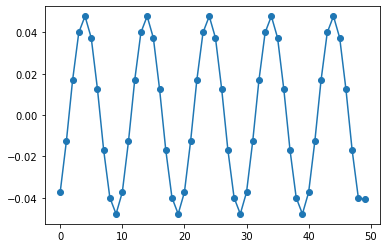

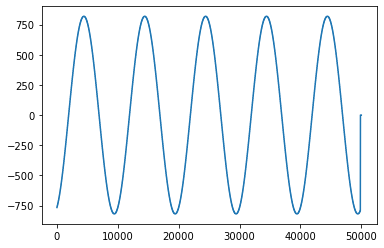

In [4]:

num_segments = 50

seg_length = long_pulse_len // (4 * num_segments)

config["integration_weights"]["xWeights"]["cosine"] = [0.1] * num_segments * seg_length
config["integration_weights"]["xWeights"]["sine"] = [0.0] * num_segments * seg_length
config["integration_weights"]["yWeights"]["sine"] = [0.1] * num_segments * seg_length
config["integration_weights"]["yWeights"]["cosine"] = [0.0] * num_segments * seg_length
QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()
QM1 = QMm.open_qm(config)
with program() as measureProg:
    ind = declare(int)
    I = declare(fixed)
    update_frequency("qe1",0.1e6)
    int_stream = declare_stream()
    
    sliced_integration_res = declare(fixed, size=int(num_segments))
    
    measure("readoutOp2","qe1","raw",integration.sliced("x", sliced_integration_res, seg_length),)

    with for_(ind, 0, ind < num_segments, ind + 1):
        save(sliced_integration_res[ind], int_stream)

    
    with stream_processing():
        int_stream.save_all("int_sliced")
    
job = QM1.simulate(measureProg,SimulationConfig(40000, simulation_interface=LoopbackInterface([("con1", 1, "con1", 1)])),)
res = job.result_handles
res.wait_for_all_values()
plt.figure()
plt.plot(res.int_sliced.fetch_all()['value'], "o-")
plt.show()

plt.figure()
plt.plot(res.raw_input1.fetch_all()['value'])
plt.show()


## Excercises

1. Play a sinusoidal pulse at 50 MHz and display the output trace in the time domain
2. 